In [1]:
!pip install --quiet --upgrade flwr
!pip install --quiet --upgrade tensorflow-cpu
!pip install --quiet --upgrade scikit-learn
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.1 requires keras<2.15,>=2.14.0, but you have keras 2.15.0 which is incompatible.
tensorflow 2.14.1 requires tensorboard<2.15,>=2.14, but you have tensorboard 2.15.2 which is incompatible.
tensorflow 2.14.1 requires tensorflow-estimator<2.15,>=2.14.0, but you have tensorflow-estimator 2.15.0 which is incompatible.
tensorflow-privacy 0.8.12 requires pandas~=1.4, but you have pandas 2.2.0 which is incompatible.


In [2]:
import collections
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

/tmp/ipykernel_3978/148713579.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_train = pd.read_csv('/workspaces/Network_Intrusion_Detection/train_180_cicflow.csv')
df_test = pd.read_csv('/workspaces/Network_Intrusion_Detection/test_180_cicflow.csv')

In [4]:
df_train.dtypes

Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max       int64
Idle Min       int64
Label         object
Length: 84, dtype: object

In [5]:

df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [6]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [7]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [8]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

/tmp/ipykernel_3978/3176878993.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
/tmp/ipykernel_3978/3176878993.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)


In [9]:
train = df_train.iloc[:,7:]
test = df_test.iloc[:,7:]

In [10]:
train.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.rename(columns={"Label": "y"}, inplace=True, errors="raise")

In [11]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
train.dropna(inplace=True)
test.dropna(inplace=True)

In [12]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [13]:
n_workers = 3
n_samples = int(train.shape[0] / n_workers)

In [14]:
client_data = []
train_copy = train.copy()

for i in range(n_workers):
    sample = train_copy.sample(n=n_samples)
    sample.to_csv(f'client_data_{i+1}.csv', index=False)
    train_copy.drop(index=sample.index, inplace=True)
    client_data.append(sample)

In [15]:
for i in range(n_workers):
    print(f"Worker {i+1} training data contains {len(client_data[i])} points")

Worker 1 training data contains 1196 points
Worker 2 training data contains 1196 points
Worker 3 training data contains 1196 points


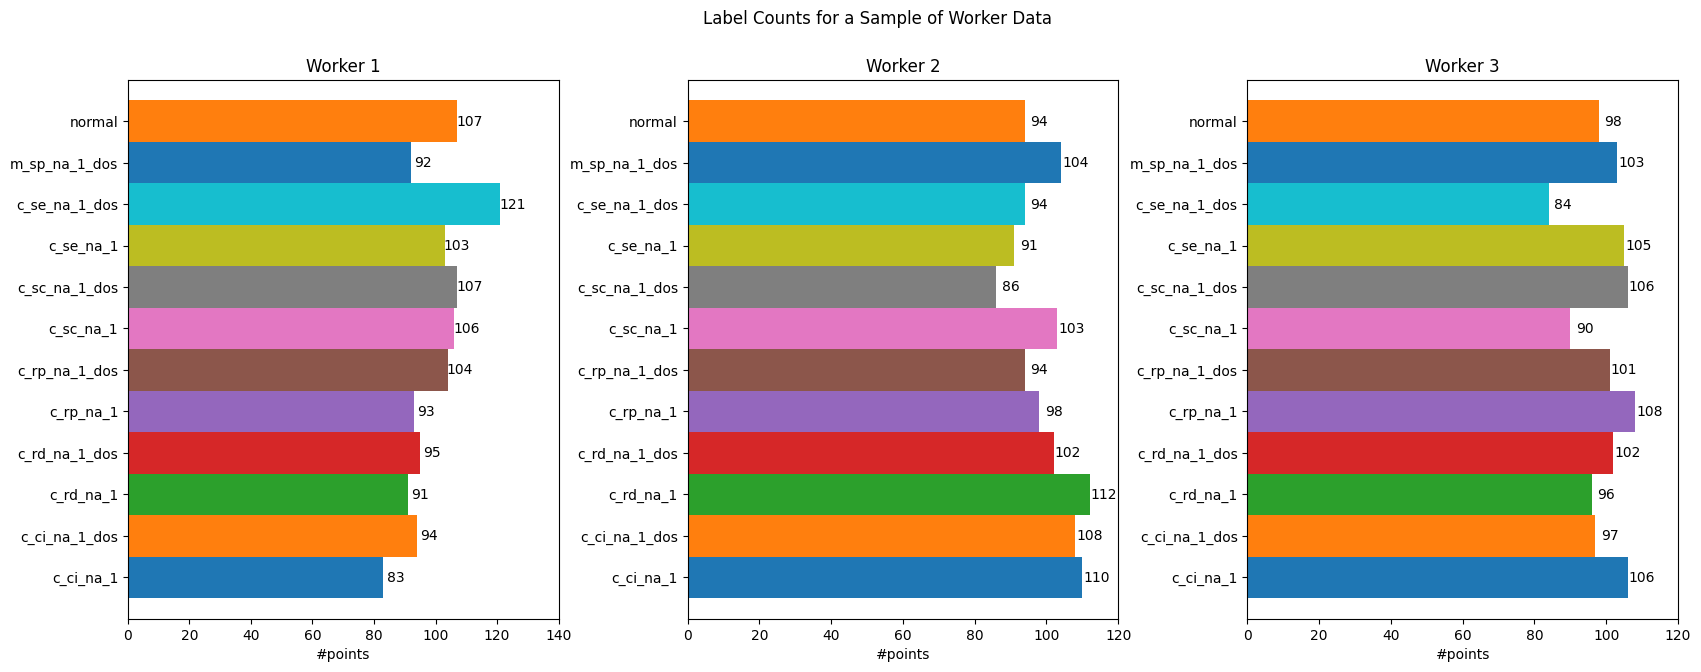

In [16]:
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    sample = client_data[i]
    for label in sample['y']:
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(20-m%20)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    # plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+4, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

2024-02-14 10:25:00.526091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
scaler = MinMaxScaler()

In [19]:
X_train_scaled = scaler.fit_transform(train.drop(['y'], axis=1).to_numpy())
y_train = train['y'].to_numpy()
X_test_scaled = scaler.transform(test.drop(['y'], axis=1).to_numpy())
y_test = test['y'].to_numpy()

In [20]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=y_train_cat.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [25]:
model.fit(x=X_train_scaled, 
          y=y_train_cat, 
          epochs=100,
          validation_data=(X_test_scaled, y_test_cat),
          verbose=1,
          batch_size=64,
          callbacks=[early_stop]
          )

Epoch 1/100
30/57 [==============>...............] - ETA: 0s - loss: 0.8379 - accuracy: 0.5760

57/57 [==============================] - 0s 4ms/step - loss: 0.8553 - accuracy: 0.5669 - val_loss: 1.0678 - val_accuracy: 0.5283
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 0.8615 - accuracy: 0.5644 - val_loss: 1.0425 - val_accuracy: 0.5446
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.8739 - accuracy: 0.5624 - val_loss: 1.0560 - val_accuracy: 0.5479
Epoch 4/100
57/57 [==============================] - 0s 4ms/step - loss: 0.8627 - accuracy: 0.5658 - val_loss: 1.0604 - val_accuracy: 0.5349
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 0.8611 - accuracy: 0.5546 - val_loss: 1.0490 - val_accuracy: 0.5498
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 0.8677 - accuracy: 0.5577 - val_loss: 1.0683 - val_accuracy: 0.5479
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 0.8535 - accuracy: 0.5591 - val_loss: 1.0507 - val_accuracy: 0.5511
Epoch 8/100
57/57 [======

<Axes: >

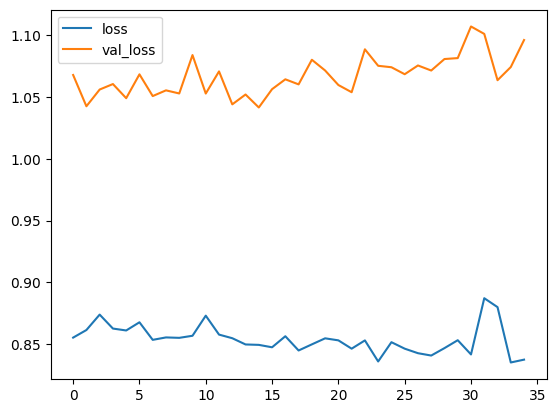

In [26]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss','val_loss']].plot()

In [27]:
print("Loss, Accuracy: ", model.evaluate(X_test_scaled, y_test_cat))
model.compute_loss()

48/48 [==============================] - 0s 1ms/step - loss: 1.0961 - accuracy: 0.5446
Loss, Accuracy:  [1.0960625410079956, 0.5446254014968872]


In [28]:
print("F1-score: ", f1_score(y_test, np.argmax(model.predict(X_test_scaled), axis=1), average='weighted'))

48/48 [==============================] - 0s 2ms/step
F1-score:  0.5238434650418085
